# Logistic Regression

Logistic regression is the most common binary classification algorithm. It predicts continuous values between 0 and 1 to classify something as 0 or 1. The regression predicts a value based on features and will ascribe the value to a class based on whether the value falls above or below a pre-set threshold.  

In [12]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib.pyplot as plt
import math
from sklearn import metrics as metrics
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import wordnet

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [13]:
# Reading in dataframe
df = pd.read_csv('../Data/casual_political.csv')

In [14]:
df.head()

,binary_sub,NN,NNP,VBG,PRP,VBP,TO,VB,IN,CC,...,DT,RB,RBR,PRP$,VBN,vader_negative,vader_positive,vader_neutral,vader_compound,lemma_totaltext
0,1,0.172185,0.059603,0.033113,0.046358,0.052980,0.033113,0.066225,0.145695,0.039735,...,0.125828,0.039735,0.000000,0.000000,0.019868,0.070,0.127,0.802,0.9173,Could the Senate move for a motion of no confi...
1,1,0.107143,0.023810,0.000000,0.047619,0.047619,0.011905,0.059524,0.095238,0.047619,...,0.095238,0.071429,0.000000,0.000000,0.083333,0.206,0.073,0.721,-0.8732,Should verbal error by presidential candidate ...
2,0,0.131429,0.000000,0.034286,0.154286,0.057143,0.017143,0.034286,0.148571,0.051429,...,0.062857,0.051429,0.011429,0.028571,0.034286,0.141,0.083,0.777,-0.8438,I finally get bang today after a year of go ba...
3,0,0.202020,0.060606,0.030303,0.090909,0.020202,0.010101,0.030303,0.131313,0.040404,...,0.121212,0.070707,0.000000,0.000000,0.000000,0.113,0.059,0.827,-0.7461,Is it just me or do anyone else feel no differ...
4,1,0.131148,0.000000,0.032787,0.049180,0.065574,0.049180,0.065574,0.131148,0.049180,...,0.131148,0.032787,0.000000,0.016393,0.000000,0.126,0.168,0.707,0.4847,What be some issue both Democrats and Republic...


## Baseline Model

The most basic baseline model is the probability of predicting the major class. As we found out in the EDA section, the major class is CasualConversations because there are more posts from that subreddit than the PoliticalDiscussion subreddit

In [15]:
df['binary_sub'].value_counts(normalize=True)

0    0.501446
1    0.498554
Name: binary_sub, dtype: float64

Our baseline model accuracy is thus 50.1%, about equal to predicting a coin flip. We need to be able to improve significantly upon this score to have trust in our model!

## Model Pre-Processing

Before we fit our logistic regression, we need to split our data into training and testing datasets, implement the Term Frequency - Inverse Document Frequency (TF-IDF) vectorization to account for words that are outliers as well as weight words depending on their importance to the sentence, and standardize the feature values so that we can compare the values of each feature on the same scale when fitting the model .  

In [16]:
# Splitting data into preditive features and resulting feature
X = df.drop(columns='binary_sub')
y = df['binary_sub']

In [17]:
# Splitting data further into a model training set and a model testing set. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

### TF-IDF 

TF-IDF acconts for the importance of a word in a corpus of documents by measuring its frequency in a document relative to its total frequency in all of the documents. In this case, one document is a single post in either subreddit, and the total documents are all the posts in both subreddits. 

Only perform TF-IDF vectorization on the lemma_totaltext feature, so I will have to concatenate the TF-IDF vector DataFrame with the DataFrame including all of my original features. 

To make the vectorization more impactful, I removed stop words (commonly used words that do not convey much meaning) and outlier words (words that occur less than 3 times in all documents). 

In [18]:
# Removing stop words and outlier words from tfidf corpus of words
tvec = TfidfVectorizer(stop_words='english', min_df=3)

In [19]:
# Fit and transforming training lemma text with TFIDF
X_train_tvec = tvec.fit_transform(X_train['lemma_totaltext'])

# Transforming test lemma totaltext based on training fit
X_test_tvec = tvec.transform(X_test['lemma_totaltext'])

In [20]:
# All totaltext words that were vectorized
vocab = tvec.get_feature_names()

Have to make sure all TF-IDF vectors are dense so that matrix is rank efficient. It also ensures that the vectors do not take up too much unnecessary space in the DataFrame.

In [21]:
# Creating dense DataFrame of all training vectors
train_tvec_df = pd.DataFrame(X_train_tvec.todense(), columns=vocab)

# Creating dense Dataframe of all test vectors
test_tvec_df = pd.DataFrame(X_test_tvec.todense(), columns=vocab)

Creating Dataframes with all features minus the lemma_totaltext, which was just vectorized and made into a separate DataFrame

In [22]:
X_train_clean = X_train.drop(columns='lemma_totaltext')

In [23]:
# Have to drop index to concatenate TF-IDF Vector DataFrame and original DataFrame 
#X_train_clean.reset_index(drop=True, inplace=True)

In [24]:
# Creating clean test DataFrame minus the lemma_totaltext
X_test_clean = X_test.drop(columns='lemma_totaltext')

Standard Scaling is necessary because the VADER Sentiment scores are on a different scale than the other features. 

In [25]:
# Standard Scaling the clean train and test DataFrame
ss = StandardScaler()
Z_train_clean = ss.fit_transform(X_train_clean)
Z_test_clean = ss.transform(X_test_clean)



In [26]:
# Standard Scaling the TF-IDF vector DataFrame 
sc = StandardScaler()

Z_tvec_train = sc.fit_transform(train_tvec_df)
Z_tvec_test = sc.transform(test_tvec_df)

In [27]:
# Concatenating the standard scaled original feature dataframe vectors 
# and TF-IDF vector DataFrame
train_vec = np.concatenate([Z_train_clean, Z_tvec_train], axis=1)


In [28]:
#X_test_clean.reset_index(drop=True, inplace=True)

In [29]:
test_vec = np.concatenate([Z_test_clean, Z_tvec_test], axis=1)
#test = pd.concat([Z_test_clean, test_tvec_df], axis=1)

### Fitting Logistic Regression Model 1

In [30]:
# Insantietating Logistic Regression
lr = LogisticRegression()

In [31]:
# Fitting the model to our train standard scaled vectors. 
lr.fit(train_vec, y_train)

LogisticRegression()

In [32]:
# Find mean accuracy of logistic regression on training data
train_accuracy = lr.score(train_vec, y_train)
train_accuracy

1.0

In [33]:
# Cross-validating the logistic regression to determine what accuracy might 
# be for testing data
scores = cross_val_score(lr, train_vec, y_train, cv = 5)

print('Accuracy: {:.2f} ± {:.2f}'.format(scores.mean(), scores.std() * 2))

Accuracy: 0.98 ± 0.00


In [34]:
# Finding Mean accuracy of logistic regression model on test data
test_accuracy = lr.score(test_vec, y_test)
test_accuracy

0.9862911266201396

### Analysis of Logistic Regression Model 1

The training and testing accuracy are very similar at 100% accurate and 98.2% accurate , which suggests that the model is not overfit or underfit. However, I am curious if I can still improve the testing accuracy with a GridSearch. 

### Fitting Logistic Regression Model 2
#### GridSearch Logistic Regression Hyper-Paramters

I will now run the logistic regression with a pipeline which automatically fits and transforms the training data with TF-IDF vectorizer before fitting the logistic regression. The gridsearchCV will then run different combinations of logistic regression parameters and return the best parameters based on the optimal accuracy score from all of the different combinations. 

* The solver parameter consists of different logistic regression methods that can potentially be used by LogisticRegression method.
* The penalty parameter dictates the type of regularization the logistic regression uses for reducing the variance error. L1 is the lasso regularization, and L2 is the Ridge regularization. 
* The logistic C is a regularization hyperparameter. The smaller it is, the stronger the regularization, and thus the less variance error in the model. 

In [35]:
# Constructing pipeline
pipe = Pipeline([
    
    ('tvec', TfidfVectorizer(analyzer='word', stop_words='english')),
    ('lr', LogisticRegression())
    
])

In [36]:
# Creating dictionary of parameters to gridsearch over
params = {
    'lr__solver': ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga'],
    'lr__penalty': ['l1', 'l2'],
    'lr__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

In [37]:
# Instantietating gridsearch with pipeline
gs = GridSearchCV(pipe, param_grid=params, n_jobs=-1)

In [38]:
# Creating new X_train variable specifically for the pipeline
# Only lemmatized text are going to be used as predictor
gs_train = X_train['lemma_totaltext']

In [39]:
# Filtering out warnings so as not to pollute code.
warnings.filterwarnings("ignore")

In [40]:
# Gridsearching hyperparameters through pipeline
gs.fit(gs_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'lr__penalty': ['l1', 'l2'],
                         'lr__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                        'sag', 'saga']})

In [41]:
# Best parameters from the grid search 
gs.best_params_

{'lr__C': 100, 'lr__penalty': 'l2', 'lr__solver': 'sag'}

In [42]:
# Training accuracy
gs_train_accuracy = gs.score(gs_train, y_train)
gs_train_accuracy
#print(f'Train Accuracy: {gs_train_accuracy}')

1.0

In [43]:
# Creating testing variable
gs_test = X_test['lemma_totaltext']

In [44]:
# Evaluating the accuracy of the model on testing data
gs_test_accuracy = gs.score(gs_test, y_test)
gs_test_accuracy

0.9900299102691924

The model improved slightly with grid search and reducing features so that only lemmatized text is used as predictor.

#### Logistic Regression Model 3 

What is the model accuracy with all features and hyperparameters chosen by previous gridsearch?

In [45]:
new_lr = LogisticRegression(solver='saga', penalty='l2', C=1000)

In [46]:
new_lr.fit(train_vec, y_train)

LogisticRegression(C=1000, solver='saga')

In [47]:
new_train_accuracy = new_lr.score(train_vec, y_train)
new_train_accuracy

0.9998753583447588

In [48]:
new_test_accuracy = new_lr.score(test_vec, y_test)
new_test_accuracy

0.9865403788634097

#### Analysis 
Essentially the same accuracy as the model with less features, therefore only need to use lemmatized total text for subsequent models. While Part-of-Speech tagging and sentiment analysis provided interesting information, they were not ultimately useful features for modeling compared to just looking at the vocabulary within the post. 

## Evaluating Logistic Regression and Best Features 

Based on the fact that our best Logistic Regression testing score occurred without the parts-of-speech proportions or sentiment analysis, it is safe to assume that the the lemmatized total text itself are the only features required for producing an accurate model. Therefore, I will only be using the lemmatized total text for future models. 

#### Coefficient Weights

To determine which words had the largest impact on our model, we can analyze each word's contribution to the total logistic regression slope. We do so by evaluating the beta coefficients produced by the logistic regression, which is each features slope contribution to total slope. 
Because this is a logistic regression, the slope is in log(odds), but we can transform this to odds to evaluate how each predictor (or lemmatized word), holding other predictors constant, leads to a change in the independent variable for a 1 standard deviation increase in the predictor (because the predictors are StandardScaled). 

In [49]:
# Getting beta coefficients from GridSearch 
coefs = gs.best_estimator_.named_steps['lr'].coef_

In [50]:
# Getting vocabulary words associated with beta coefficients
vocab = gs.best_estimator_.named_steps['tvec'].get_feature_names()

In [51]:
# Creating a DataFrame of top words contributing to slope and their corresponding slope
coef_df = pd.DataFrame({'top_words': vocab, 'log(odds)': coefs[0]})

In [52]:
# Calculating how feature increases the odds of text being political 
coef_df['odds'] = coef_df['log(odds)'].map(lambda x: math.exp(x))

In [53]:
# Setting index to be the words
coef_df.set_index('top_words', inplace=True)

In [54]:
# Most political words (i.e. political text identifying words)
political_words = coef_df.sort_values('odds', ascending=False).head(9)
political_words

,log(odds),odds
top_words,,
trump,23.080033,1.055676e+10
political,21.735012,2.750398e+09
politics,17.974812,6.402679e+07
election,16.316837,1.219866e+07
president,15.211991,4.040954e+06
candidate,14.820706,2.732440e+06
hillary,13.276444,5.832927e+05
vote,12.949629,4.206806e+05
clinton,12.229806,2.048035e+05


In [55]:
# Most casual words (i.e. words that are the most casual)
casual_words = coef_df.sort_values('odds').head(15)

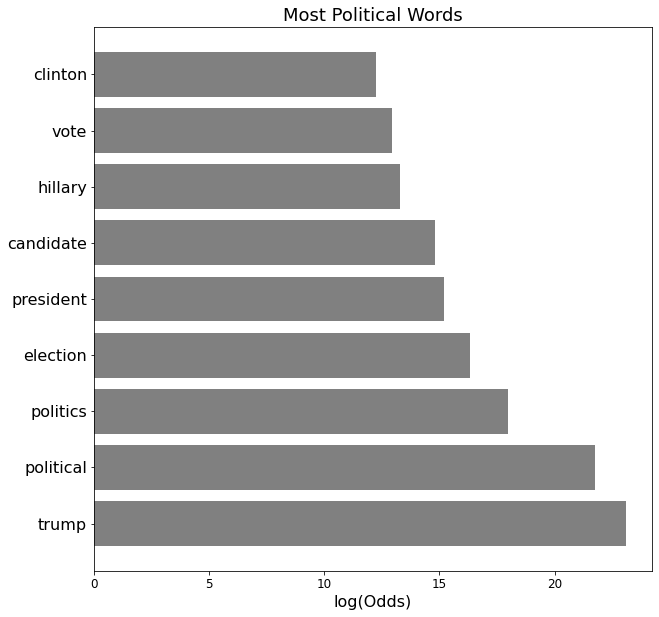

In [57]:
plt.figure(figsize=(10,10))
plt.barh(political_words.index, political_words['log(odds)'], color='grey')
plt.title('Most Political Words', fontsize=18)
plt.xlabel('log(Odds)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=12)
plt.savefig('../Figures/most_political_words.png')

#### Analysis

For my random forest model, I need to remove "politics" and "political" from the lemmatized text in order to determine whether they are causing data leakage, leading to abnormally high accuracy rate. However, there are many other words with large slopes that are helping differentiate casual from political conversations, particular proper nouns (names of politicians).  

Casual words are the words that contribute the lowest log(odds), they are the worst predictors of political context

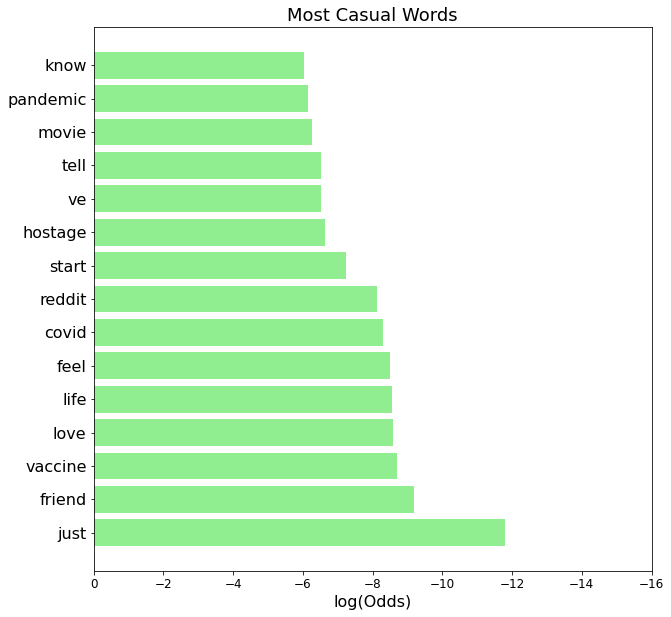

In [58]:
plt.figure(figsize=(10,10))
plt.barh(casual_words.index, casual_words['log(odds)'], color='lightgreen')
plt.xlim((0, -16))
plt.title('Most Casual Words', fontsize=18)
plt.xticks(fontsize=12)
plt.xlabel('log(Odds)', fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('../Figures/most_casual_words.png');

#### Analysis

There is a huge discrepancy between the log odds of very political words and casual words. I am getting great separation between the vocabulary of political and casual conversations.

#### Classification Metrics

In order to evaluate the model, I need to be able to evaluate how many posts were classified correctly, and how many posts were classified incorrectly. In order to do so, I can use classification metrics that illuminate how many outcomes were true positives (correctly predicted political text), false positives (incorrectly predicted political text), false negatives (icorrectly predicted casual text), and true negatives (correctly predicted casual text). 

In [59]:
# y predictions using grid search variable created earlier
y_hat = gs.predict(gs_test)

In [60]:
# Creating DataFrame to help me remember which confusion matrix quadrants
# Correspond to which outcomes. 
cm = np.array([['True Negative', 'False Positive'],
                            ['False Negative', 'True Positive']])

cm = pd.DataFrame(cm,columns = ['Pred Casual', 'Pred Political'], 
                      index = ['Actual Casual','Actual Political'])

,Pred Casual,Pred Political
Actual Casual,True Negative,False Positive
Actual Political,False Negative,True Positive


<Figure size 720x720 with 0 Axes>

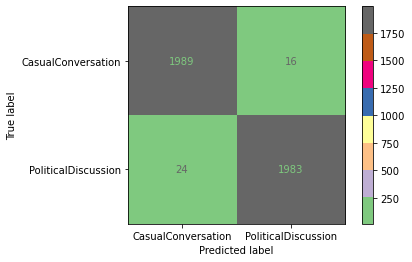

In [61]:
# Displaying sample confusion matrix
display(cm)

# Displaying actual confusion matrix 
plt.figure(figsize=(10,10))
metrics.plot_confusion_matrix(gs, gs_test, y_test, cmap='Accent', 
                      values_format='d', display_labels=['CasualConversation', 
                                                         'PoliticalDiscussion']);

My model predicted:

* 1983 True Positives (Correctly predicted r/PoliticalDiscussion)
* 1984 True Negatives (Correctly predicted r/CasualConversation)
* 24 False Negatives (Incorrectly predicted r/CasualConversation)
* 21 False Positives (Incorrectly predicted r/PoliticalDiscussion)

Overall, these are fantastic ratios and indicate that I am on the right path for differentiating between the casual and political discussions. 

### ROC curve

The ROC curve tells us how separated our two classes, CasualConversations and PoliticalDiscussions, are. The more area under the blue curve, the larger the separation between the two classes. 

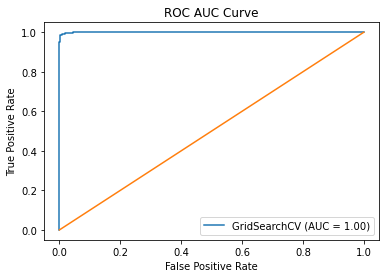

In [62]:
# ROC curve
metrics.plot_roc_curve(gs, gs_test, y_test)
# add worst case scenario line
plt.plot([0, 1], [0, 1])
plt.title('ROC AUC Curve');

#### Analysis
My ROC curve shows that the CasualConversation and PoliticalDiscussion classes are perfectly separated, indicating my model is as good as it can get. This was also seen by the high degree of separation in the log(odds) of the political and casual words. 

In [63]:
# ROC AUC score nearly 1
metrics.roc_auc_score(y_test, y_hat)

0.9900309018186969

* Accuracy: What percentage of political and casual texts did I correctly predict? 
* Sensitivity: Among political texts, what percentage of texts did I correctly predict?
* Specificity: Among casual texts, what percentage of texts did I correctly predict? 
* Precision: Among those I predicted to be political texts, what percentage of texts did I correctly predict?

In [64]:
accuracy = metrics.accuracy_score(y_test, y_hat)

#specificity = true negative/(true neagtive +false positive)
specificity = 1984/(1984+21) 

sensitivity =  metrics.recall_score(y_test, y_hat)

precision = metrics.precision_score(y_test, y_hat)

In [65]:
print('My accuracy is: ', round(accuracy,2))
print('My specificity is: ', round(specificity, 2))
print('My sensitivity is: ', round(sensitivity,2))
print('My precision is: ', round(precision,2))

My accuracy is:  0.99
My specificity is:  0.99
My sensitivity is:  0.99
My precision is:  0.99


In [66]:
# Creating classification report 
print(metrics.classification_report(y_test, y_hat, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2005
           1       0.99      0.99      0.99      2007

    accuracy                           0.99      4012
   macro avg       0.99      0.99      0.99      4012
weighted avg       0.99      0.99      0.99      4012



The F1 score is the harmonic mean of precision and sensitivity (recall). It tells me how well I was able to predict 




Model Summary Table:

|Model| Train Accuracy| Test Accuracy| AUC ROC| True Positive| True Negative| False Positive| False Negative|
|---|---|---|---|---|---|---|---|
|Logistic Regression| 1.0|0.989|0.989|1983|1984|21|24|

### Conclusion 

My logistic regressionmodel performed extremely well. However, I want to analyze whether it performed so well due to data leakage by leaving the politic lemma in my totaltext. 

# Please Continue to Notebook 3B